# Exploration and plot generation
This notebook generates many plots based on spells and spells_21_days.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import chain
from collections import Counter
import re
import seaborn as sns  # for easier grouped histogram
import numpy as np

base = Path("/n/scratch/users/b/bef299/polypharmacy_project_fhd8SDd3U50/")


# --- Load data ---
input_suffix = "_opioid_sample5M"
output_suffix = "_opioid_sample5M_grace15_minspell7_ae_censoring"
spells = pd.read_parquet(base / f"spells_with_labels{output_suffix}.parquet")
split_spells = pd.read_parquet(base / f"split_spells{output_suffix}.parquet")

# Filter out rows with len(drug_combo) < 3 (due to a bug that I was not able to fix, I suspect it is related to the GRACE PERIOD at the end of the spells)
before_count = len(split_spells)
split_spells = split_spells[split_spells["drug_combo"].map(len) >= 3]
after_count = len(split_spells)
print(f"Filtered out {before_count - after_count} rows with drug_combo length < 3, about {((before_count - after_count) / before_count) * 100:.2f}% of the data.")

# rx_fills = pd.read_parquet(base / f"rx_fills{input_suffix}.parquet")
demographics = pd.read_parquet(base / f"demographics{input_suffix}.parquet")
comorbidities = pd.read_parquet(base / f"icd10_codes_from_spells{output_suffix}_clustered.parquet")
try:
    drug_changes = pd.read_parquet(base / f"drug_changes{output_suffix}.parquet")
except FileNotFoundError:
    print("Drug changes file not found.")
    drug_changes = pd.DataFrame()

Filtered out 213370 rows with drug_combo length < 3, about 11.89% of the data.


📊 Summary of Gaps Between Spells (raw_exit → next entry)
-----------------------------------------------------------------
Mean:     157.97 days
Median:    54.00 days
Std:      280.40 days
Min:          16 days
Max:        3963 days
Count:   394,487
-----------------------------------------------------------------


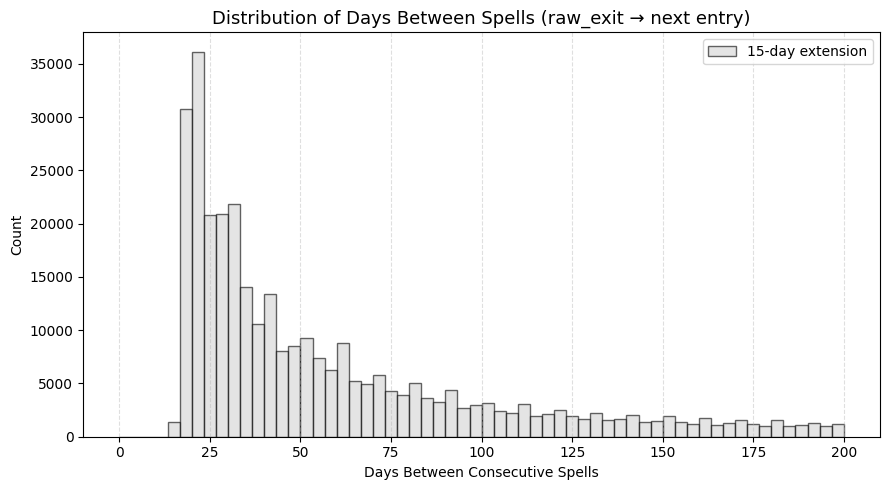

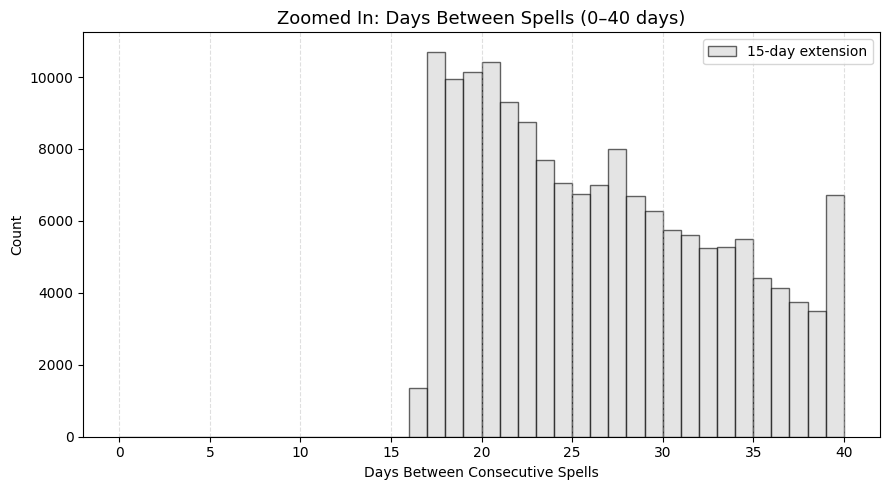

In [2]:
# --- Gap Between Spells (raw_exit → next entry) ---

def compute_gaps(spells_df: pd.DataFrame) -> pd.Series:
    """Compute gap in days between consecutive spells for each patient."""
    # Ensure datetime types
    date_cols = ["entry_date", "raw_exit_date", "extended_exit_date", "followup_end_date"]
    for col in date_cols:
        if col in spells_df.columns and not np.issubdtype(spells_df[col].dtype, np.datetime64):
            spells_df[col] = pd.to_datetime(spells_df[col])

    # Sort and compute gap between raw_exit_date of previous spell and next entry_date
    spells_sorted = spells_df.sort_values(["MemberUID", "entry_date"]).copy()
    spells_sorted["days_since_prev_raw_exit"] = (
        spells_sorted["entry_date"] 
        - spells_sorted.groupby("MemberUID")["raw_exit_date"].shift(1)
    ).dt.days

    return spells_sorted["days_since_prev_raw_exit"].dropna()



# Compute gaps for both versions
gaps = compute_gaps(spells)

# --- Summary stats ---
print("📊 Summary of Gaps Between Spells (raw_exit → next entry)")
print("-" * 65)
print(f"Mean:   {gaps.mean():8.2f} days")
print(f"Median: {gaps.median():8.2f} days")
print(f"Std:    {gaps.std():8.2f} days")
print(f"Min:    {gaps.min():8.0f} days")
print(f"Max:    {gaps.max():8.0f} days")
print(f"Count:  {len(gaps):8,}")
print("-" * 65)

# --- Plot full histogram (0–200 days for clarity) ---
plt.figure(figsize=(9, 5))
plt.hist(gaps, bins=60, range=(0, 200), alpha=0.6, label="15-day extension", color="lightgray", edgecolor="black")
plt.title("Distribution of Days Between Spells (raw_exit → next entry)", fontsize=13)
plt.xlabel("Days Between Consecutive Spells")
plt.ylabel("Count")
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# --- Zoomed-in histogram (0–40 days) ---
plt.figure(figsize=(9, 5))
plt.hist(gaps, bins=40, range=(0, 40), alpha=0.6, label="15-day extension", color="lightgray", edgecolor="black")
plt.title("Zoomed In: Days Between Spells (0–40 days)", fontsize=13)
plt.xlabel("Days Between Consecutive Spells")
plt.ylabel("Count")
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [3]:
# --- 🧮 Spell summary comparison Split vs non-split---

def summarize_spells(df):
    """Get spell summary statistics."""
    total = len(df)
    one_per = len(df.drop_duplicates(subset=["MemberUID"], keep="first"))
    return total, one_per, one_per / total * 100

# Summaries
total, one, pct = summarize_spells(spells)
total_split, one_split, pct_split = summarize_spells(split_spells)


print("📊 Spell Summary Comparison")
print("-" * 60)
print(f"{'Config':<20}{'Total Spells':>15}{'1/Patient':>15}{'% of Total':>10}")
print("-" * 60)
print(f"{'Spells':<20}{total:>15,}{one:>15,}{pct:>9.2f}%")
print(f"{'Split Spells':<20}{total_split:>15,}{one_split:>15,}{pct_split:>9.2f}%")
print("-" * 60)

# Keep only the one-per-patient spells for further analysis
# spells = spells.drop_duplicates(subset=["MemberUID"], keep="first")


📊 Spell Summary Comparison
------------------------------------------------------------
Config                 Total Spells      1/Patient% of Total
------------------------------------------------------------
Spells                      634,355        239,868    37.81%
Split Spells              1,581,017        225,784    14.28%
------------------------------------------------------------



📋 Top Adverse Event Codes and Descriptions
--------------------------------------------------------------------------------
CodeValue  count                                                                                         Description  % of Total
    F1120   3907                                              Mental and behavioural disorders due to use of opioids       41.20
    F1190   1023                                              Mental and behavioural disorders due to use of opioids       10.79
  T7840XA    839                                                            Adverse effects not elsewhere classified        8.85
  T451X5A    640       Poisoning by adverse effect of and underdosing of drugs medicaments and biological substances        6.75
    F1920    627  Mental and behavioural disorders due to multiple drug use and use of other psychoactive substances        6.61
  T402X5A    568       Poisoning by adverse effect of and underdosing of drugs medicaments and biolog

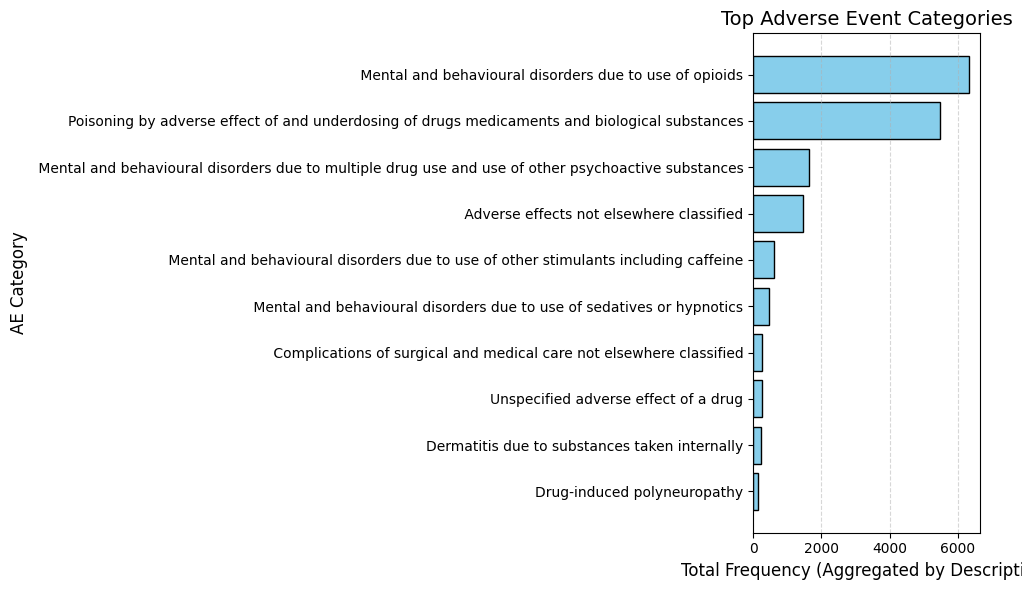


🧮 Aggregated AE Category Counts (for plot)
                                                                                        Description  count
                                             Mental and behavioural disorders due to use of opioids   6328
      Poisoning by adverse effect of and underdosing of drugs medicaments and biological substances   5469
 Mental and behavioural disorders due to multiple drug use and use of other psychoactive substances   1635
                                                           Adverse effects not elsewhere classified   1462
                 Mental and behavioural disorders due to use of other stimulants including caffeine    607
                              Mental and behavioural disorders due to use of sedatives or hypnotics    472
                                Complications of surgical and medical care not elsewhere classified    260
                                                               Unspecified adverse effect of a drug 

In [4]:
# --- ⚙️ Flatten AE codes across all AE spells ---
# If 'first_ae_code' doesn’t exist, replace it with your AE column (e.g. 'ae_codes')
ae_freq_df = (
    split_spells[split_spells["had_ae"]]["first_ae_code"]
    .value_counts()
    .reset_index()
    .rename(columns={"first_ae_code": "CodeValue"})
)

# --- 📖 Read mapping CSV (with lazy SQL-like patterns) ---
ae_map = pd.read_csv("data/icd10_codes.csv")  # columns: code, description

def map_description(code):
    """Return AE description using SQL-like % wildcards."""
    for _, row in ae_map.iterrows():
        pattern = row["code"].replace("%", "")
        if str(code).startswith(pattern):
            return row["description"]
    return "Unknown AE code"

# Map descriptions
ae_freq_df["Description"] = ae_freq_df["CodeValue"].apply(map_description)

# --- 📊 Summary Table of Top AE Codes ---
top_n = 10
top_ae_df = ae_freq_df.head(top_n).copy()
top_ae_df["% of Total"] = (
    top_ae_df["count"] / top_ae_df["count"].sum() * 100
).round(2)

print("\n📋 Top Adverse Event Codes and Descriptions")
print("-" * 80)
print(top_ae_df.to_string(index=False))
print("-" * 80)
print(f"Showing top {top_n} AE categories out of {len(ae_freq_df):,} total unique codes.\n")

# --- 🔢 Aggregate by Description for visualization ---
agg_by_desc = (
    ae_freq_df.groupby("Description", as_index=False)["count"]
    .sum()
    .sort_values("count", ascending=False)
)

# Take top N descriptions for plotting
top_desc = agg_by_desc.head(top_n)

# --- 🎨 Visualization ---
plt.figure(figsize=(10, 6))
plt.barh(top_desc["Description"], top_desc["count"], color="skyblue", edgecolor="black")
plt.gca().invert_yaxis()  # Highest on top
plt.title("Top Adverse Event Categories", fontsize=14)
plt.xlabel("Total Frequency (Aggregated by Description)", fontsize=12)
plt.ylabel("AE Category", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- 🧮 Print small summary of aggregation ---
print("\n🧮 Aggregated AE Category Counts (for plot)")
print(top_desc.to_string(index=False))

print("Total Adverse Events Counted:", ae_freq_df["count"].sum())


📊 AE Positioning Within Spell (original spells)
------------------------------------------------------------
count    19383.000000
mean       106.033844
std        198.673379
min          0.000000
25%          8.000000
50%         30.000000
75%        106.500000
max       3340.000000
Name: days_into_spell, dtype: float64

📊 AE Positioning Within Spell (split_spells)
------------------------------------------------------------
count    17605.000000
mean        13.780801
std         23.458266
min          0.000000
25%          0.000000
50%          6.000000
75%         18.000000
max        480.000000
Name: days_into_spell, dtype: float64


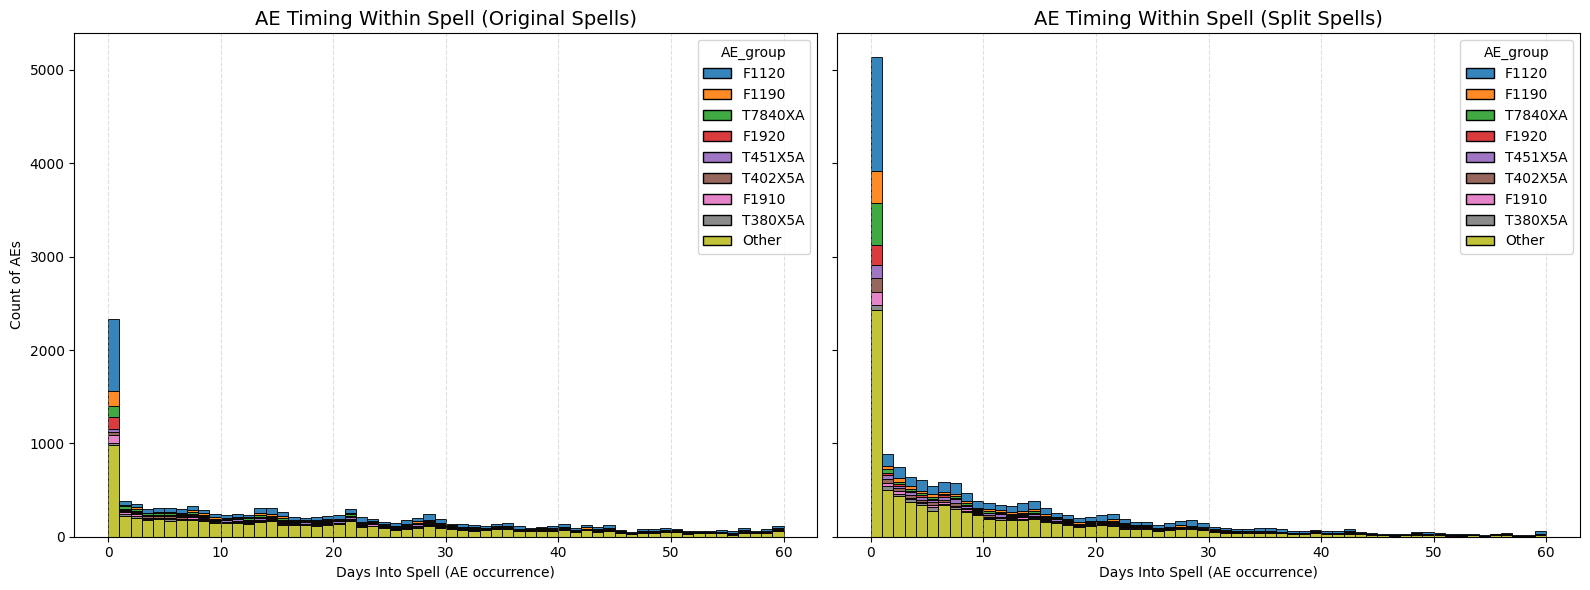

In [5]:
# --- 🧭 AE positioning within spells and split_spells (days into spell) ---

def prepare_ae_spells(df: pd.DataFrame) -> pd.DataFrame:
    """Subset to spells with AE, ensure dates, and compute days_into_spell."""
    ae_df = df[df["had_ae"]].copy()
    ae_df["entry_date"] = pd.to_datetime(ae_df["entry_date"])
    ae_df["first_ae_date"] = pd.to_datetime(ae_df["first_ae_date"])
    ae_df["days_into_spell"] = (ae_df["first_ae_date"] - ae_df["entry_date"]).dt.days
    return ae_df

ae_spells = prepare_ae_spells(spells)
ae_spells_split = prepare_ae_spells(split_spells)

# --- 📊 Summaries ---
print("\n📊 AE Positioning Within Spell (original spells)")
print("-" * 60)
print(ae_spells["days_into_spell"].describe())

print("\n📊 AE Positioning Within Spell (split_spells)")
print("-" * 60)
print(ae_spells_split["days_into_spell"].describe())

# --- 🧩 Identify top AE categories (pooled, for consistent palette) ---
top_n = 8
pooled_codes = pd.concat(
    [ae_spells["first_ae_code"], ae_spells_split["first_ae_code"]],
    ignore_index=True
)
top_codes = pooled_codes.value_counts().head(top_n).index.tolist()

def add_ae_group(df: pd.DataFrame, top_codes: list) -> pd.DataFrame:
    df = df.copy()
    df["AE_group"] = df["first_ae_code"].apply(
        lambda x: x if x in top_codes else "Other"
    )
    return df

ae_spells = add_ae_group(ae_spells, top_codes)
ae_spells_split = add_ae_group(ae_spells_split, top_codes)

# Shared hue order and palette (same colors across both plots)
ae_categories = top_codes + ["Other"]
palette_colors = sns.color_palette("tab10", n_colors=len(ae_categories))
palette_map = dict(zip(ae_categories, palette_colors))

# --- 🎨 Plot histograms side by side with shared palette ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.histplot(
    data=ae_spells,
    x="days_into_spell",
    hue="AE_group",
    hue_order=ae_categories,
    palette=palette_map,
    bins=60,
    binrange=(0, 60),
    multiple="stack",
    edgecolor="black",
    alpha=0.9,
    ax=axes[0]
)
axes[0].set_title("AE Timing Within Spell (Original Spells)", fontsize=14)
axes[0].set_xlabel("Days Into Spell (AE occurrence)")
axes[0].set_ylabel("Count of AEs")
axes[0].grid(axis="x", linestyle="--", alpha=0.4)

sns.histplot(
    data=ae_spells_split,
    x="days_into_spell",
    hue="AE_group",
    hue_order=ae_categories,
    palette=palette_map,
    bins=60,
    binrange=(0, 60),
    multiple="stack",
    edgecolor="black",
    alpha=0.9,
    ax=axes[1]
)
axes[1].set_title("AE Timing Within Spell (Split Spells)", fontsize=14)
axes[1].set_xlabel("Days Into Spell (AE occurrence)")
axes[1].set_ylabel("Count of AEs")
axes[1].grid(axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


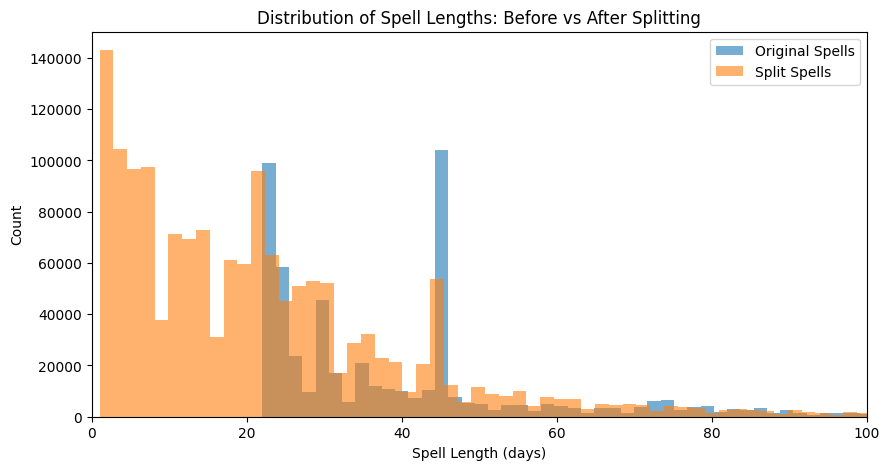

Original Spells Summary:
count    634355.000000
mean         73.972449
std         130.652432
min          22.000000
25%          26.000000
50%          42.000000
75%          61.000000
max        3448.000000
Name: spell_length_days, dtype: float64

Split Spells Summary:
count    1.581017e+06
mean     2.388099e+01
std      2.543753e+01
min      1.000000e+00
25%      7.000000e+00
50%      1.900000e+01
75%      3.100000e+01
max      8.890000e+02
Name: spell_length_days, dtype: float64


In [6]:
# --- 1. Distribution of spell lengths before and after splitting ---

import matplotlib.pyplot as plt

# Original spell lengths
spell_lengths = spells['spell_length_days']

# Split spell lengths
split_spell_lengths = split_spells['spell_length_days']

# Plot
plt.figure(figsize=(10,5))
plt.hist(spell_lengths, bins=2000, alpha=0.6, label='Original Spells')
plt.hist(split_spell_lengths, bins=500, alpha=0.6, label='Split Spells')
plt.xlabel('Spell Length (days)')
plt.ylabel('Count')
plt.xlim(0, 100)  # Set x-axis limits
plt.title('Distribution of Spell Lengths: Before vs After Splitting')
plt.legend()
plt.show()

# Summary statistics
print("Original Spells Summary:")
print(spell_lengths.describe())
print("\nSplit Spells Summary:")
print(split_spell_lengths.describe())


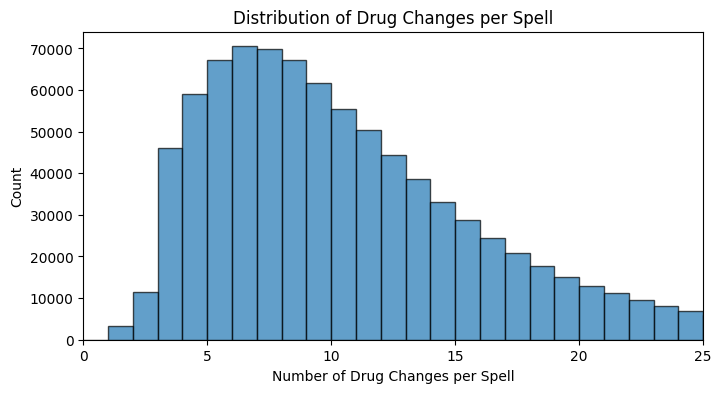

count    888368.000000
mean         11.456829
std           9.338512
min           1.000000
25%           6.000000
50%           9.000000
75%          14.000000
max         869.000000
dtype: float64


In [7]:
# --- 2. Distribution of number of drug changes per spell ---

# Count drug changes per spell_id
drug_changes_per_spell = (
    drug_changes[drug_changes['change_type'] == 'add']
        .groupby('spell_id')
        .size()
)
# Plot
plt.figure(figsize=(8,4))
plt.hist(drug_changes_per_spell, bins=range(0, drug_changes_per_spell.max()+2), edgecolor='black', alpha=0.7)
plt.xlabel('Number of Drug Changes per Spell')
plt.ylabel('Count')
plt.xlim(0, 25)  # Focus on 0-20 range for clarity
plt.title('Distribution of Drug Changes per Spell')
plt.show()

# Summary statistics
print(drug_changes_per_spell.describe())


# Remove drops


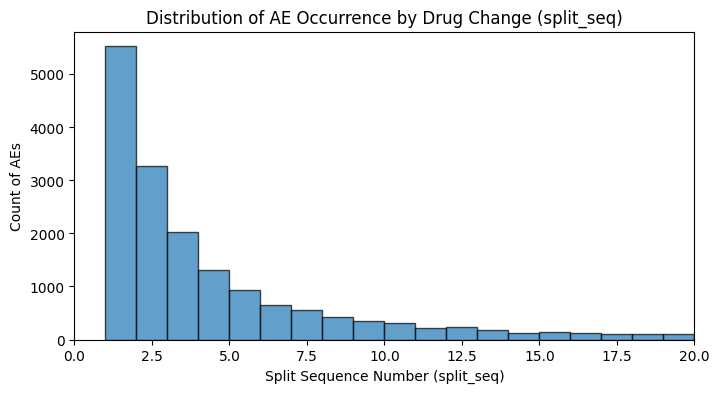

split_seq
1      5526
2      3262
3      2022
4      1303
5       926
       ... 
103       1
109       2
121       1
132       1
146       1
Name: count, Length: 95, dtype: int64


In [8]:
# --- 3. At which drug change does AE occur (split_seq) ---

# Filter split spells that had an AE
ae_spells = split_spells[split_spells['had_ae'] == True]

# Distribution of AE occurrence by split_seq
plt.figure(figsize=(8,4))
plt.hist(ae_spells['split_seq'], bins=range(1, ae_spells['split_seq'].max()+2), edgecolor='black', alpha=0.7)
plt.xlabel('Split Sequence Number (split_seq)')
plt.ylabel('Count of AEs')
plt.xlim(0, 20)
plt.title('Distribution of AE Occurrence by Drug Change (split_seq)')
plt.show()

# Summary
print(ae_spells['split_seq'].value_counts().sort_index())


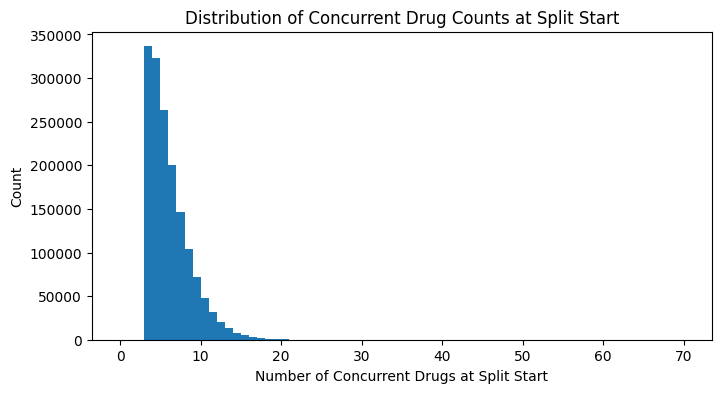

Most common 3-drug combos at split start (with ATC names):


,Count,Drug Combo (with ATC Names)
9,5594,M01A (ANTIINFLAMMATORY AND ANTIRHEUMATIC PRODU...
8,4798,A02B (DRUGS FOR PEPTIC ULCER AND GASTRO-OESOPH...
7,2977,M01A (ANTIINFLAMMATORY AND ANTIRHEUMATIC PRODU...
6,2700,M01A (ANTIINFLAMMATORY AND ANTIRHEUMATIC PRODU...
5,2658,"M03B (MUSCLE RELAXANTS, CENTRALLY ACTING AGENT..."
4,2171,"N02A (OPIOIDS), N02B (OTHER ANALGESICS AND ANT..."
3,2122,"N02A (OPIOIDS), N05B (ANXIOLYTICS), N06A (ANTI..."
2,1918,"J01C (BETA-LACTAM ANTIBACTERIALS, PENICILLINS)..."
1,1897,"M03B (MUSCLE RELAXANTS, CENTRALLY ACTING AGENT..."
0,1574,A02B (DRUGS FOR PEPTIC ULCER AND GASTRO-OESOPH...


Most common 4-drug combos at split start (with ATC names):


,Count,Drug Combo (with ATC Names)
9,1240,M01A (ANTIINFLAMMATORY AND ANTIRHEUMATIC PRODU...
8,799,"M03B (MUSCLE RELAXANTS, CENTRALLY ACTING AGENT..."
7,787,M01A (ANTIINFLAMMATORY AND ANTIRHEUMATIC PRODU...
6,733,"H02A (CORTICOSTEROIDS FOR SYSTEMIC USE, PLAIN)..."
5,669,M01A (ANTIINFLAMMATORY AND ANTIRHEUMATIC PRODU...
4,665,"A01A (STOMATOLOGICAL PREPARATIONS), A02B (DRUG..."
3,575,A02B (DRUGS FOR PEPTIC ULCER AND GASTRO-OESOPH...
2,524,A02B (DRUGS FOR PEPTIC ULCER AND GASTRO-OESOPH...
1,504,M01A (ANTIINFLAMMATORY AND ANTIRHEUMATIC PRODU...
0,490,"N02A (OPIOIDS), N02B (OTHER ANALGESICS AND ANT..."


Total distinct individual drugs across all splits: 202


In [5]:
# --- 4. Derive concurrent drug combos at split start ---

# Load 	NDC_to_ATC_levels1234_clean.csv from the scratch directory, only keep atc_3_code, atc_3_name, and drop all duplicates
ndc_to_atc = pd.read_csv("/n/scratch/users/b/bef299/polypharmacy_project_fhd8SDd3U50/NDC_to_ATC_levels1234_clean.csv")
ndc_to_atc = ndc_to_atc[["atc_3_code", "atc_3_name"]].drop_duplicates()

# Number of concurrent drugs at split start
split_spells["concurrent_drugs"] = split_spells["drug_combo"].apply(len)

# Simple histogram
plt.figure(figsize=(8, 4))
plt.hist(split_spells["concurrent_drugs"], bins=range(0, split_spells["concurrent_drugs"].max() + 2))
plt.xlabel("Number of Concurrent Drugs at Split Start")
plt.ylabel("Count")
plt.title("Distribution of Concurrent Drug Counts at Split Start")
plt.show()

# --- Show most common 3-drug combos with ATC names included ---
three_drug_combos = split_spells[split_spells["concurrent_drugs"] == 3]["drug_combo"]
combo_counts = Counter(tuple(sorted(combo)) for combo in three_drug_combos)
common_codes = pd.DataFrame(combo_counts.most_common(10),
                            columns=["Drug Combo", "Count"])
common_expanded = (
    common_codes
    .explode("Drug Combo")  # one ATC code per row
    .rename(columns={"Drug Combo": "atc_3_code"})
)
common_expanded = common_expanded.merge(ndc_to_atc, on="atc_3_code", how="left")
common_expanded["drug_label"] = common_expanded["atc_3_code"] + " (" + common_expanded["atc_3_name"] + ")"
annotated = (
    common_expanded
    .groupby("Count")["drug_label"]
    .apply(lambda labels: ", ".join(sorted(labels)))
    .reset_index()
    .rename(columns={"drug_label": "Drug Combo (with ATC Names)"})
    .merge(common_codes[["Drug Combo", "Count"]], on="Count")
    .drop(columns=["Drug Combo"])
    [["Count", "Drug Combo (with ATC Names)"]]  # reorder
    .sort_values("Count", ascending=False)
)
print("Most common 3-drug combos at split start (with ATC names):")
# Save as a CSV file
# annotated.to_csv("most_common_3_drug_combos_with_atc_names_5M.csv", index=False)
display(annotated)

# Show the most common drug combos for 4 concurrent drugs
four_drug_combos = split_spells[split_spells["concurrent_drugs"] == 4]["drug_combo"]
combo_counts = Counter(tuple(sorted(combo)) for combo in four_drug_combos)
common_codes = pd.DataFrame(combo_counts.most_common(10),
                            columns=["Drug Combo", "Count"])
common_expanded = (
    common_codes
    .explode("Drug Combo")  # one ATC code per row
    .rename(columns={"Drug Combo": "atc_3_code"})
)
common_expanded = common_expanded.merge(ndc_to_atc, on="atc_3_code", how="left")
common_expanded["drug_label"] = common_expanded["atc_3_code"] + " (" + common_expanded["atc_3_name"] + ")"
annotated = (
    common_expanded
    .groupby("Count")["drug_label"]
    .apply(lambda labels: ", ".join(sorted(labels)))
    .reset_index()
    .rename(columns={"drug_label": "Drug Combo (with ATC Names)"})
    .merge(common_codes[["Drug Combo", "Count"]], on="Count")
    .drop(columns=["Drug Combo"])
    [["Count", "Drug Combo (with ATC Names)"]]  # reorder
    .sort_values("Count", ascending=False)
)
print("Most common 4-drug combos at split start (with ATC names):")
# Save as a CSV file
# annotated.to_csv("most_common_4_drug_combos_with_atc_names_5M.csv", index=False)
display(annotated)

# Number of distinct individual drugs across all splits
all_drugs = set(chain.from_iterable(split_spells["drug_combo"]))
print(f"Total distinct individual drugs across all splits: {len(all_drugs)}")

In [13]:
from collections import Counter
from itertools import chain
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

# Step 0: Remove all rows from the same MemberUID that have the same drug_combo to avoid patient-level confounding. If one of the rows has an AE, keep that one.

def deduplicate_member_drug_combos(df: pd.DataFrame) -> pd.DataFrame:
    """
    Deduplicate by (MemberUID, combo_key), preferring rows with had_ae == True.
    If multiple AE rows exist for the same combo, keeps the first in original order.
    """
    # Sort so that:
    #  - groups are together (MemberUID, combo_key)
    #  - within each group, AE rows (had_ae == True) come first
    df_sorted = df.sort_values(
        ["MemberUID", "combo_key", "had_ae"],
        ascending=[True, True, False],
        kind="mergesort"  # stable sort preserves original order among ties
    )

    # Drop duplicates, keeping the first row in each (MemberUID, combo_key) group
    deduped = (
        df_sorted
        .drop_duplicates(subset=["MemberUID", "combo_key"], keep="first")
        .reset_index(drop=True)
    )

    return deduped


# --- 1. Make a canonical key for each drug combo (sorted tuple of ATC-3 codes) ---
split_spells["combo_key"] = split_spells["drug_combo"].apply(lambda combo: tuple(sorted(combo)))

print("Split spells before deduplication:", len(split_spells))
split_spells_dedup = deduplicate_member_drug_combos(split_spells)
print("Split spells after deduplication:", len(split_spells_dedup))

# Subset with AEs
ae_spells = split_spells_dedup[split_spells_dedup["had_ae"] == True]

# --- 2. Count total spells and AE spells per combo ---
total_counts = split_spells_dedup.groupby("combo_key").size().rename("n_total")
ae_counts = ae_spells.groupby("combo_key").size().rename("n_ae")

combo_summary = (
    pd.concat([total_counts, ae_counts], axis=1)
    .fillna(0)
    .assign(n_ae=lambda df: df["n_ae"].astype(int))
)
combo_summary["n_no_ae"] = combo_summary["n_total"] - combo_summary["n_ae"]
combo_summary["ae_prop"] = combo_summary["n_ae"] / combo_summary["n_total"]

print(f"Overall AE proportion: {split_spells_dedup['had_ae'].mean():.4f}")

# --- 3. Focus on combos with at least 200 total occurrences ---
min_n = 200
combo_summary_filt = combo_summary[combo_summary["n_total"] >= min_n].copy()

# --- 4. Build contingency tables and test for higher AE proportion ---

# Overall AE / non-AE counts across all spells
overall_n = len(split_spells_dedup)
overall_ae = split_spells_dedup["had_ae"].sum()
overall_no_ae = overall_n - overall_ae

def chi2_pvalue_vs_rest(row):
    """
    2x2 table for:
        rows: [this combo, all other spells]
        cols: [AE, no AE]
    """
    a = row["n_ae"]
    b = row["n_no_ae"]
    c = overall_ae - a
    d = overall_no_ae - b
    table = np.array([[a, b],
                      [c, d]])
    chi2, p, dof, expected = chi2_contingency(table)
    return p

combo_summary_filt["p_value"] = combo_summary_filt.apply(chi2_pvalue_vs_rest, axis=1)

# --- 5. Benjamini–Hochberg FDR correction (multiple testing) ---
combo_summary_filt = combo_summary_filt.sort_values("p_value")
m = len(combo_summary_filt)
ranks = np.arange(1, m + 1)
# Raw BH adjustment
combo_summary_filt["p_fdr"] = combo_summary_filt["p_value"] * m / ranks
# Enforce monotone non-decreasing p_fdr
combo_summary_filt["p_fdr"] = combo_summary_filt["p_fdr"].cummin()

# Optional: keep only combos with *higher than overall* AE rate and significant after FDR
overall_ae_rate = overall_ae / overall_n
signal_combos = combo_summary_filt[
    (combo_summary_filt["ae_prop"] > overall_ae_rate) &
    (combo_summary_filt["p_fdr"] < 0.05)
].copy()

# --- 6. Make it a bit more readable: bring the combo back as a column ---
combo_summary_filt = combo_summary_filt.reset_index().rename(columns={"combo_key": "drug_combo"})

print("Top combos by AE proportion (n_total >= 200):")
display(
    combo_summary_filt.sort_values("ae_prop", ascending=False)
    .head(20)[["drug_combo", "n_total", "n_ae", "ae_prop", "p_value", "p_fdr"]]
)

print("\nCombos with significantly higher AE proportion (FDR < 0.05):")
display(
    signal_combos.reset_index()
    .rename(columns={"combo_key": "drug_combo"})
    [["drug_combo", "n_total", "n_ae", "ae_prop", "p_value", "p_fdr"]]
)


# Assuming ndc_to_atc already loaded as in your previous cell
# ndc_to_atc has columns: atc_3_code, atc_3_name

# Start from the significant combos (or combo_summary_filt if you want all)
sig = signal_combos.reset_index().rename(columns={"combo_key": "drug_combo"})
sig["combo_id"] = np.arange(len(sig))  # helper ID

expanded = (
    sig[["combo_id", "drug_combo", "n_total", "n_ae", "n_no_ae", "ae_prop", "p_value", "p_fdr"]]
    .explode("drug_combo")  # one ATC code per row
    .rename(columns={"drug_combo": "atc_3_code"})
    .merge(ndc_to_atc, on="atc_3_code", how="left")
)

expanded["drug_label"] = expanded["atc_3_code"] + " (" + expanded["atc_3_name"] + ")"

annotated = (
    expanded
    .groupby("combo_id")
    .apply(lambda df: pd.Series({
        "Drug Combo (with ATC Names)": ", ".join(sorted(df["drug_label"].dropna().unique())),
        "n_total": df["n_total"].iloc[0],
        "n_ae": df["n_ae"].iloc[0],
        "n_no_ae": df["n_no_ae"].iloc[0],
        "ae_prop": df["ae_prop"].iloc[0],
        "p_value": df["p_value"].iloc[0],
        "p_fdr": df["p_fdr"].iloc[0],
    }))
    .reset_index(drop=True)
    .sort_values(["p_fdr", "ae_prop"])
)

print("Drug combos with significantly elevated AE rate (with ATC names):")
display(annotated.head(50))
# Optionally save:
annotated.to_csv("ae_enriched_drug_combos_with_atc_names.csv", index=False)


Split spells before deduplication: 1581017
Split spells after deduplication: 1460495
Overall AE proportion: 0.0120
Top combos by AE proportion (n_total >= 200):


,drug_combo,n_total,n_ae,ae_prop,p_value,p_fdr
0,"(N05B, N06A, N07B)",210,27,0.128571,6.239330e-52,1.528636e-49
8,"(A06A, N02A, N02B)",213,7,0.032864,1.347725e-02,1.528636e-49
5,"(N02A, N05B, R06A)",295,9,0.030508,8.294347e-03,1.528636e-49
12,"(M01A, M03B, N02A, N02B, N06A)",280,8,0.028571,2.377261e-02,1.528636e-49
30,"(N02A, N05A, N05B, N06A)",224,6,0.026786,8.619407e-02,1.528636e-49
7,"(A02B, M01A, N02A, N02B)",412,11,0.026699,1.239982e-02,1.528636e-49
16,"(N02A, N02B, N03A)",408,10,0.024510,3.745256e-02,1.528636e-49
25,"(B01A, N02A, N02B)",329,8,0.024316,7.388402e-02,1.528636e-49
66,"(M01A, N02A, N03A, N06A)",218,5,0.022936,2.447101e-01,1.528636e-49
29,"(N02A, N02B, N05B, N06A)",395,9,0.022785,8.439615e-02,1.528636e-49



Combos with significantly higher AE proportion (FDR < 0.05):


,drug_combo,n_total,n_ae,ae_prop,p_value,p_fdr
0,"(N05B, N06A, N07B)",210,27,0.128571,6.239330e-52,1.528636e-49
1,"(M03B, N02A, N02B)",2124,40,0.018832,5.625157e-03,1.528636e-49
2,"(N02A, N05B, R06A)",295,9,0.030508,8.294347e-03,1.528636e-49
3,"(A02B, M01A, N02A, N02B)",412,11,0.026699,1.239982e-02,1.528636e-49
4,"(A06A, N02A, N02B)",213,7,0.032864,1.347725e-02,1.528636e-49
...,...,...,...,...,...,...
68,"(H02A, N02A, N05B)",381,5,0.013123,1.000000e+00,1.528636e-49
69,"(N02A, N02B, N05C)",412,5,0.012136,1.000000e+00,1.528636e-49
70,"(N02A, N05B, N06B)",223,3,0.013453,1.000000e+00,1.528636e-49
71,"(N02A, N05B, R01A)",228,3,0.013158,1.000000e+00,1.528636e-49


Drug combos with significantly elevated AE rate (with ATC names):


/tmp/ipykernel_2051933/83439536.py:137: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.Series({


,Drug Combo (with ATC Names),n_total,n_ae,n_no_ae,ae_prop,p_value,p_fdr
69,"N02A (OPIOIDS), N02B (OTHER ANALGESICS AND ANT...",412,5,407,0.012136,1.000000,1.528636e-49
67,"J01F (MACROLIDES, LINCOSAMIDES AND STREPTOGRAM...",246,3,243,0.012195,1.000000,1.528636e-49
72,"N02A (OPIOIDS), N05C (HYPNOTICS AND SEDATIVES)...",649,8,641,0.012327,1.000000,1.528636e-49
56,M01A (ANTIINFLAMMATORY AND ANTIRHEUMATIC PRODU...,2514,31,2483,0.012331,0.968894,1.528636e-49
65,"C03A (LOW-CEILING DIURETICS, THIAZIDES), C10A ...",237,3,234,0.012658,1.000000,1.528636e-49
59,A02B (DRUGS FOR PEPTIC ULCER AND GASTRO-OESOPH...,619,8,611,0.012924,0.987437,1.528636e-49
68,"H02A (CORTICOSTEROIDS FOR SYSTEMIC USE, PLAIN)...",381,5,376,0.013123,1.000000,1.528636e-49
71,"N02A (OPIOIDS), N05B (ANXIOLYTICS), R01A (DECO...",228,3,225,0.013158,1.000000,1.528636e-49
63,"C10A (LIPID MODIFYING AGENTS, PLAIN), M01A (AN...",225,3,222,0.013333,1.000000,1.528636e-49
38,"M03B (MUSCLE RELAXANTS, CENTRALLY ACTING AGENT...",1566,21,1545,0.013410,0.704931,1.528636e-49


count    36272.000000
mean        29.629963
std         25.924323
min          1.000000
25%         11.000000
50%         22.000000
75%         40.000000
max        247.000000
Name: n_codes, dtype: float64

icd10_codes
I10    18956
M54    16762
Z79    16651
E78    15780
M25    15125
Z68    14819
M79    13366
Z01    13318
G89    11305
Z00    11165
Z12    11042
R10    10826
Z23    10805
F41    10637
K21    10011
E66     9862
R06     9417
Z87     9153
E11     9145
R07     9067
Name: count, dtype: int64

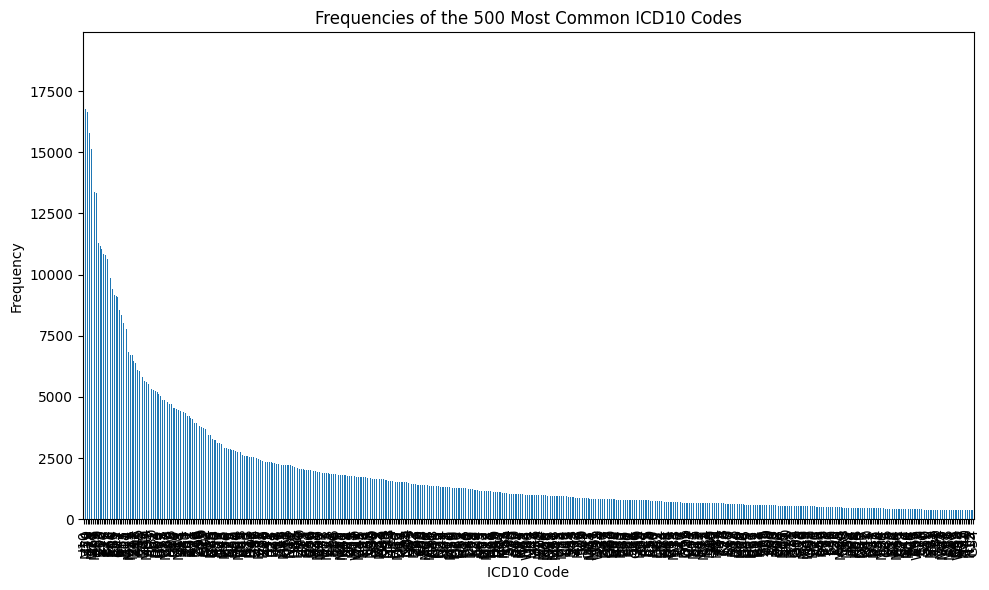

Total distinct ICD10 codes in dataset: 1871


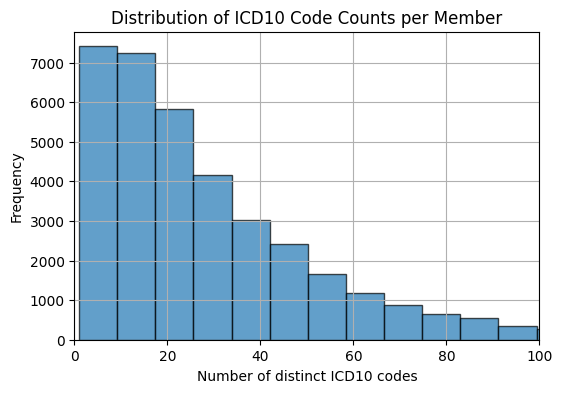

In [ ]:
# Show the comorbidities per patient
# Group by MemberUID and collapse to distinct ICD10 codes per member
member_icd = (
    comorbidities
    .explode("icd10_codes")               # one code per row
    .drop_duplicates(["MemberUID", "icd10_codes"])
)

# --- Descriptive statistics ---

# 1. Count of unique ICD10 codes per member
code_counts = (
    member_icd.groupby("MemberUID")["icd10_codes"]
    .nunique()
    .rename("n_codes")
)
display(code_counts.describe())

# 2. Most common ICD10 codes overall
common_codes = (
    member_icd["icd10_codes"]
    .value_counts()
    .head(20)
)
display(common_codes)

# Plot the frequencies of the 500 most common ICD10 codes
plt.figure(figsize=(10, 6))
common_500 = (
    member_icd["icd10_codes"]
    .value_counts()
    .head(500)
)
common_500.plot(kind='bar')
plt.title("Frequencies of the 500 Most Common ICD10 Codes")
plt.xlabel("ICD10 Code")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Amount of distinct ICD10 codes in all the dataset, no grouping per member
distinct_icd10_codes = member_icd["icd10_codes"].nunique()
print(f"Total distinct ICD10 codes in dataset: {distinct_icd10_codes}")


# 3. Distribution of number of codes per member
import matplotlib.pyplot as plt

# Suppress x-axis labels for clarity
plt.figure(figsize=(6,4))
code_counts.hist(bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Number of distinct ICD10 codes")
plt.ylabel("Frequency")
plt.xlim(0,100)
plt.title("Distribution of ICD10 Code Counts per Member")
plt.show()


In [21]:
# --- 👥 Demographics Comparison: AE vs Non-AE ---

ae_spells = split_spells[split_spells["had_ae"]].copy()

# Define AE and Non-AE members
ae_members = ae_spells["MemberUID"].unique()
non_ae_members = split_spells.loc[~split_spells["MemberUID"].isin(ae_members), "MemberUID"].unique()
ae_demo = demographics[demographics["MemberUID"].isin(ae_members)].copy()
non_ae_demo = demographics[demographics["MemberUID"].isin(non_ae_members)].copy()

print(f"\n📊 Demographics Summary")
print("-" * 60)
print(f"AE patients: {len(ae_demo):,}")
print(f"Non-AE patients: {len(non_ae_demo):,}")
print("-" * 60)

# --- Gender distribution ---
gender_ae = ae_demo["gendercode"].value_counts(normalize=True).rename("AE (%)") * 100
gender_non = non_ae_demo["gendercode"].value_counts(normalize=True).rename("Non-AE (%)") * 100
gender_table = pd.concat([gender_ae, gender_non], axis=1).fillna(0).round(2)

# --- Race / Ethnicity distribution ---
race_ae = ae_demo["raceethnicitytypecode"].value_counts(normalize=True).rename("AE (%)") * 100
race_non = non_ae_demo["raceethnicitytypecode"].value_counts(normalize=True).rename("Non-AE (%)") * 100
race_table = pd.concat([race_ae, race_non], axis=1).fillna(0).round(2)

# --- State distribution (Top 10 AE states) ---
state_ae = ae_demo["statecode"].value_counts(normalize=True).rename("AE (%)") * 100
state_non = non_ae_demo["statecode"].value_counts(normalize=True).rename("Non-AE (%)") * 100
# Restrict to top 10 AE states for clarity
top_states = state_ae.head(10).index
state_table = pd.concat([state_ae.loc[top_states], state_non.loc[top_states]], axis=1).fillna(0).round(2)

# --- Display results ---
print("\n🧍 Gender Distribution (% of group):")
print(gender_table.to_string())

print("\n🌎 Race / Ethnicity Distribution (% of group):")
print(race_table.to_string())


📊 Demographics Summary
------------------------------------------------------------
AE patients: 3,120
Non-AE patients: 41,740
------------------------------------------------------------

🧍 Gender Distribution (% of group):
            AE (%)  Non-AE (%)
gendercode                    
F            61.67       60.29
M            38.33       39.71
U             0.00        0.00

🌎 Race / Ethnicity Distribution (% of group):
                       AE (%)  Non-AE (%)
raceethnicitytypecode                    
09                      38.21       48.01
01                      36.79       28.68
02                      13.08       10.07
06                       5.58        5.58
11                       5.51        6.25
04                       0.83        1.42
